In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import pandas as pd
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GAT
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn import preprocessing, feature_extraction
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense
import tensorflow.keras.backend as K
from stellargraph.datasets import Cora

2023-07-15 08:42:06.968274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 08:42:07.067006: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 08:42:08.569219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

In [2]:
# Load the Cora dataset
dataset = Cora()
G, node_subjects = dataset.load(subject_as_feature=True)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [3]:
edge_splitter_test = EdgeSplitter(G)

In [4]:
# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


In [5]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


In [6]:
# Preprocess node features
node_features = G_train.node_features()
node_features = preprocessing.StandardScaler().fit_transform(node_features)

# Convert node features to sparse matrix format
node_features = feature_extraction.text.TfidfTransformer().fit_transform(node_features)

# Create the link generator for GAT
generator = FullBatchLinkGenerator(G, method="gat")

In [7]:
# Create the GAT model for link prediction
gat_layer_sizes = [20, 20, 20]
gat = GAT(
    layer_sizes=gat_layer_sizes,
    # activations=["relu", "relu"],
    activations=["elu", "elu","elu"],  # better
    # activations=["relu", "sigmoid"],

    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)


In [8]:
# Define the input tensors for the GAT model
x_in, x_out = gat.in_out_tensors()

x0, x1 = tf.unstack(x_out, axis=2)
x0 = tf.squeeze(x0, axis=0)  # Remove the first dimension
x1 = tf.squeeze(x1, axis=0)  # Remove the first dimension

print(x1.shape)

concatenated_out = tf.concat([x0, x1], axis=-1)
# concatenated_out= Concatenate()([x0, x1])

dense_1 = Dense(units=64, activation='elu')(concatenated_out)
dense_2 = Dense(units=32, activation='elu')(dense_1)
prediction = Dense(units=1, activation='sigmoid')(dense_2)
prediction = tf.expand_dims(prediction, axis=0)  # Remove the first dimension

/home/saiful/anaconda3/envs/ePPI3/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


(None, 20)


In [9]:
# Generate the node representations using the GAT model
from stellargraph.layer import  link_classification
from stellargraph.layer import GCN, LinkEmbedding
from tensorflow import keras

# prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

# prediction = link_classification(
#     output_dim=1, output_act="relu", edge_embedding_method="ip"
# )(x_out)

# prediction = keras.layers.Reshape((-1,))(prediction)

print("flag 1.1 prediction.shape:" , prediction.shape)
model = keras.Model(inputs=x_in, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

flag 1.1 prediction.shape: (1, None, 1)


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 2708, 1440)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 2708, 1440)      0           ['input_1[0][0]']                
                                                                                              

In [11]:
# Train the link prediction model
train_gen = FullBatchLinkGenerator(G_train, method="gat")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)


test_gen = FullBatchLinkGenerator(G_test, method="gat")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

1/1 [==============================] - 0s 162ms/step - loss: 0.6928 - acc: 0.5489


In [12]:
print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the initial (untrained) model:
	loss: 0.6977
	acc: 0.5266

Test Set Metrics of the initial (untrained) model:
	loss: 0.6928
	acc: 0.5489


In [13]:
history = model.fit(
    train_flow, epochs=50, validation_data=test_flow, verbose=2, shuffle=False
)


Epoch 1/50


2023-07-15 08:42:21.879293: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f65440185d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-15 08:42:21.879367: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-07-15 08:42:21.894410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-15 08:42:22.514026: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 - 13s - loss: 0.7376 - acc: 0.4621 - val_loss: 0.6959 - val_acc: 0.4935 - 13s/epoch - 13s/step
Epoch 2/50
1/1 - 0s - loss: 0.7044 - acc: 0.5020 - val_loss: 0.8612 - val_acc: 0.5000 - 313ms/epoch - 313ms/step
Epoch 3/50
1/1 - 0s - loss: 0.7625 - acc: 0.5123 - val_loss: 0.7103 - val_acc: 0.4991 - 301ms/epoch - 301ms/step
Epoch 4/50
1/1 - 0s - loss: 0.7285 - acc: 0.5123 - val_loss: 0.7088 - val_acc: 0.5000 - 297ms/epoch - 297ms/step
Epoch 5/50
1/1 - 0s - loss: 0.6878 - acc: 0.5523 - val_loss: 0.7535 - val_acc: 0.5000 - 318ms/epoch - 318ms/step
Epoch 6/50
1/1 - 0s - loss: 0.7060 - acc: 0.5266 - val_loss: 0.6878 - val_acc: 0.5351 - 299ms/epoch - 299ms/step
Epoch 7/50
1/1 - 0s - loss: 0.6884 - acc: 0.5594 - val_loss: 0.6862 - val_acc: 0.5673 - 297ms/epoch - 297ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6760 - acc: 0.5748 - val_loss: 0.6991 - val_acc: 0.5212 - 303ms/epoch - 303ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6485 - acc: 0.6219 - val_loss: 0.7477 - val_acc: 0.5046 - 286ms/epoch - 286ms/st

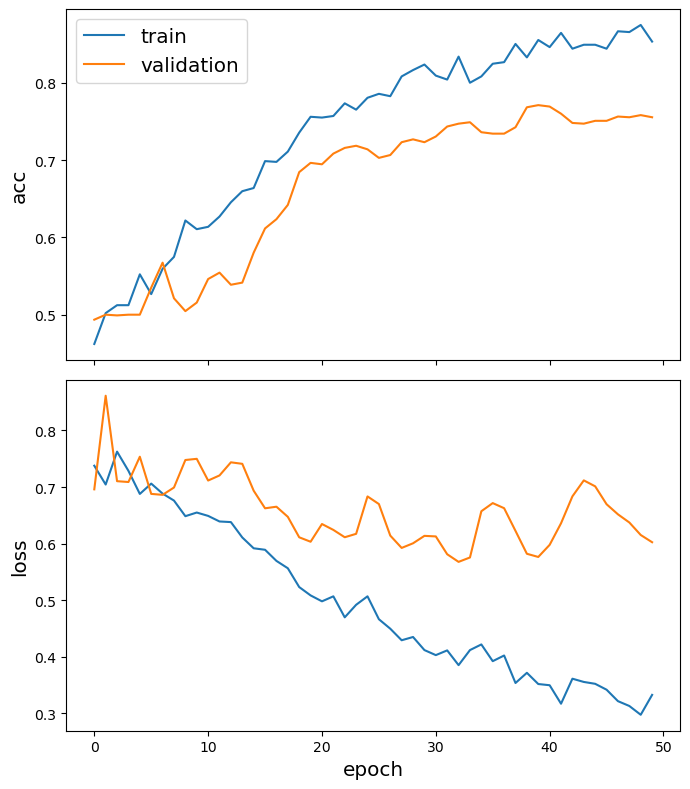

In [14]:
import stellargraph as sg

sg.utils.plot_history(history)


In [15]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)


1/1 [==============================] - 0s 142ms/step - loss: 0.6025 - acc: 0.7555


In [16]:
print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the trained model:
	loss: 0.1827
	acc: 0.9334

Test Set Metrics of the trained model:
	loss: 0.6025
	acc: 0.7555
